In [1]:
import os
import warnings

import arviz as az
import daft
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm

from causalgraphicalmodels import CausalGraphicalModel
from scipy import stats
from scipy.interpolate import griddata
from theano import shared

In [2]:
data = pd.read_csv("data/WaffleDivorce.csv",sep=';', header=0)

In [3]:
def standardize(series):
    """Standardize a pandas series"""
    std_series = (series - series.mean()) / series.std()
    return std_series
data["Divorce_std"] = standardize(data["Divorce"])
data["Marriage_std"] = standardize(data["Marriage"])
data["MedianAgeMarriage_std"] = standardize(data["MedianAgeMarriage"])

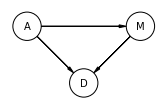

In [4]:
dag5_1 = CausalGraphicalModel(
    nodes=["A", "D", "M"], edges=[("A", "D"), ("A", "M"), ("M", "D")]
)
pgm = daft.PGM()
coordinates = {"A": (0, 0), "D": (1, 1), "M": (2, 0)}
for node in dag5_1.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag5_1.dag.edges:
    pgm.add_edge(*edge)
pgm.render()
plt.gca().invert_yaxis()

To simulate from this, we need more than the DAG. We also need a set of functions that tell
us how each variable is generated. For simplicity, we’ll use the  distributions for each
variable from model multregdiv. But model multregdiv ignored the assumption that <b>A</b> influences
<b>M</b>.We didn’t need that to estimate A → D.

But we do need it to predict the consequences
of manipulating A, because some of the effect of A acts through M.
<b>To estimate the influence of A on M, all we need is to regress A on M</b>, there are no
other variables in the DAG creating an association between A and M.

In [5]:
data["Divorce_std"] = standardize(data["Divorce"])
data["Marriage_std"] = standardize(data["Marriage"])
data["MedianAgeMarriage_std"] = standardize(data["MedianAgeMarriage"])

# Use Theano shared variables so we can change them later
marriage_shared = shared(data["Marriage_std"].values)
age_shared = shared(data["MedianAgeMarriage_std"].values)

with pm.Model() as m5_3_A:
    # A -> D <- M
    sigma = pm.Exponential("sigma", 1)
    bA = pm.Normal("bA", 0, 0.5)
    bM = pm.Normal("bM", 0, 0.5)

    a = pm.Normal("a", 0, 0.2)
    mu = pm.Deterministic("mu", a + bA * age_shared + bM * marriage_shared)
    divorce = pm.Normal("divorce", mu, sigma, observed=data["Divorce_std"])

    # A -> M
    sigma_M = pm.Exponential("sigma_m", 1)
    bAM = pm.Normal("bAM", 0, 0.5)
    aM = pm.Normal("aM", 0, 0.2)
    mu_M = pm.Deterministic("mu_m", aM + bAM * age_shared)
    marriage = pm.Normal("marriage", mu_M, sigma_M, observed=data["Marriage_std"])

    m5_3_A_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [aM, bAM, sigma_m, a, bM, bA, sigma]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:10<00:00, 182.19draws/s]


In [6]:
 # We're setting this to 50 to match the shape of our input
A_seq = np.linspace(-2, 2, 50)
A_seq.shape
# With PyMC3 we have to simulate in each model separately

# Simulate the marriage rates at each age first
age_shared.set_value(A_seq)

with m5_3_A:
    m5_3_M_marriage = pm.sample_posterior_predictive(m5_3_A_trace)

100%|██████████| 1000/1000 [00:04<00:00, 207.38it/s]


/Users/gokhansahin/opt/anaconda3/envs/MCelreath-pymc3/lib/python3.8/site-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/Users/gokhansahin/opt/anaconda3/envs/MCelreath-pymc3/lib/python3.8/site-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


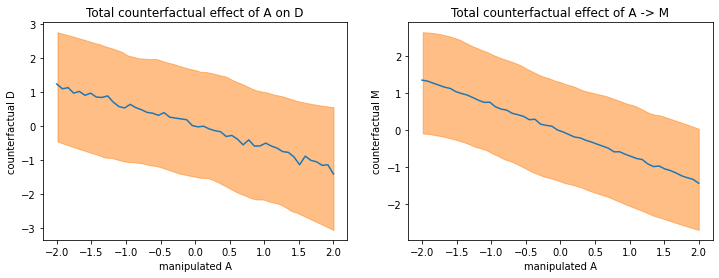

In [7]:
_, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(A_seq, m5_3_M_marriage["divorce"].mean(0))
az.plot_hpd(A_seq, m5_3_M_marriage["divorce"], ax=ax[0])
ax[0].set_title("Total counterfactual effect of A on D")
ax[0].set_xlabel("manipulated A")
ax[0].set_ylabel("counterfactual D")


ax[1].plot(A_seq, m5_3_M_marriage["marriage"].mean(0))
az.plot_hpd(A_seq, m5_3_M_marriage["marriage"], ax=ax[1])
ax[1].set_title("Total counterfactual effect of A -> M")
ax[1].set_xlabel("manipulated A")
ax[1].set_ylabel("counterfactual M");

    (left side). 
    
    
This predicted trend in D include bothpaths: A → D and A → M → D. We found previously that M → D is very small, so the second path doesn’t contribute much to the trend. But if M were to strongly influence D, the
code above would include the effect. 

The counterfactual simulation also generated values for
M. These are show on the right in Figure 5.6. The object s from the code above includes
these simulated M values. The trick with simulating counterfactuals is to realize that when we manipulate some variable X, we break the causal influence of other variables on X.This is the same as saying we modify the DAG so that no arrows enter X. Suppose for example that we now simulate
the effect of manipulating M. This implies the DAG:

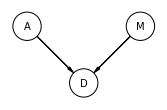

In [8]:
dag5_1 = CausalGraphicalModel(
    nodes=["A", "D", "M"], edges=[("A", "D"), ("M", "D")]
)
pgm = daft.PGM()
coordinates = {"A": (0, 0), "D": (1, 1), "M": (2, 0)}
for node in dag5_1.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag5_1.dag.edges:
    pgm.add_edge(*edge)
pgm.render()
plt.gca().invert_yaxis()

The arrow A → M is deleted, because if we control the values of M, then A no longer influences
it. It’s like a perfectly controlled experiment. Now we can modify the code above to
simulate the counterfactual result of manipulating M. We’ll simulate a counterfactual for an
average state, with A = 0, and see what changing M does.

In [10]:
# Set values for marriage counterfactual
marriage_counter_factual_x = np.linspace(-2, 2, 50)
marriage_shared.set_value(marriage_counter_factual_x)

# Fix age to zero
age_shared.set_value(np.zeros(50))

with m5_3_A:
    m5_3_M_ppc = pm.sample_posterior_predictive(m5_3_A_trace)

100%|██████████| 1000/1000 [00:04<00:00, 224.69it/s]


/Users/gokhansahin/opt/anaconda3/envs/MCelreath-pymc3/lib/python3.8/site-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


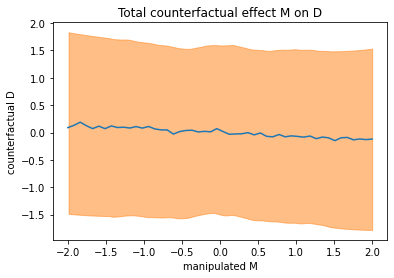

In [11]:
fig, ax = plt.subplots()

ax.plot(marriage_counter_factual_x, m5_3_M_ppc["divorce"].mean(0))
az.plot_hpd(marriage_counter_factual_x, m5_3_M_ppc["divorce"], ax=ax)
ax.set_title("Total counterfactual effect M on D")
ax.set_xlabel("manipulated M")
ax.set_ylabel("counterfactual D");

The counterfactual effect of manipulating marriage rate M on divorce rate D. Since M → D was estimated to be very small, there is almost no trend here. By manipulating M, we break the influence of A on M, and this removes the association between M and D.


<h1>Masked relationship</h1>


The divorce rate example demonstrates that multiple predictor variables are useful for
knocking out spurious association.

A second reason to use more than one predictor variable
is to measure the direct influences of multiple factors on an outcome, when none of those
influences is apparent from bivariate relationships.

This kind of problem tends to arise when
there are two predictor variables that are correlated with one another.
However, one of these
is positively correlated with the outcome and the other is negatively correlated with it.

You’ll consider this kind of problem in a new data context, information about the composition
of milk across primate species, as well as some facts about those species, like body
mass and brain size.

Milk is a huge investment, being much more expensive than gestation.
Such an expensive resource is likely adjusted in subtle ways, depending upon the physiological
and development details of each mammal species.

A popular hypothesis has it that primates with larger brains produce more energetic
milk, so that brains can
grow quickly.

The variables we’ll consider for now are:


kcal.per.g : Kilocalories of energy per gram of milk.


mass : Average female body mass, in kilograms.


neocortex.perc : The percent of total brain mass that is neocortex mass.


The question here is to what extent energy content of milk, measured here by kilocalories, is
related to the percent of the brain mass that is neocortex.

Neocortex is the gray, outer part
of the brain that is particularly elaborated in mammals and especially primates. 
We’ll end up needing female body mass as well, to see the masking that hides the relationships among
the variables. Let’s standardize these three variables. As in previous examples, standardizing
helps us both get a reliable approximation of the posterior as well as build reasonable priors

In [16]:
d = pd.read_csv('Data/milk.csv', sep=';')
d.head()


,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN


In [17]:
d["K"] = standardize(d["kcal.per.g"])
d["N"] = standardize(d["neocortex.perc"])
d["M"] = standardize(d["mass"])

The first model to consider is the simple regression between kilocalories and
neocortex percent. In mathematical form:


K<sub>i</sub> ∼ Normal(μ<sub>i</sub>, σ)

μi = α + β<sub>N</sub>N<sub>i</sub>

where K is standardized kilocalories in milk and N is standardized neocortex percent. We still need
to consider the priors. But first let’s just try to run this  model with some vague
priors, because there is another key modeling issue to address first.

In [23]:
dcc = d.dropna(axis=0)
dcc.shape


(17, 11)

In [20]:
shared_N = shared(dcc["N"].values)

with pm.Model() as m5_5_draft:
    sigma = pm.Exponential("sigma", 1)
    bN = pm.Normal("bN", 0, 1)
    a = pm.Normal("a", 0, 1)
    mu = pm.Deterministic("mu", a + bN * shared_N)

    K = pm.Normal("K", mu, sigma, observed=dcc["K"])

    m5_5_draft_trace = pm.sample()


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bN, sigma]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:07<00:00, 272.30draws/s]


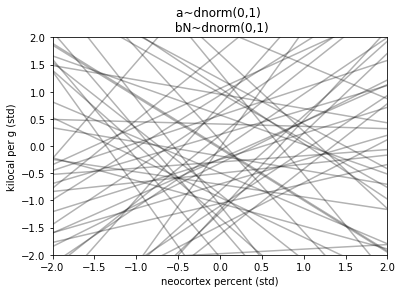

In [21]:
xseq = [-2, 2]
shared_N.set_value(np.array(xseq))
with m5_5_draft:
    m5_5_draft_prior_predictive = pm.sample_prior_predictive()
fig, ax = plt.subplots()

for i in range(50):
    ax.plot(xseq, m5_5_draft_prior_predictive["K"][i], c="black", alpha=0.3)
ax.set_xlim(xseq)
ax.set_ylim(xseq)
ax.set_title("a~dnorm(0,1) \n bN~dnorm(0,1)")
ax.set_xlabel("neocortex percent (std)")
ax.set_ylabel("kilocal per g (std)");

In [29]:
shared_N = shared(dcc["N"].values)

with pm.Model() as m5_5:
    sigma = pm.Exponential("sigma", 1)
    bN = pm.Normal("bN", 0, 0.5)
    a = pm.Normal("a", 0, 0.2)
    mu = pm.Deterministic("mu", a + bN * shared_N)

    K = pm.Normal("K", mu, sigma, observed=dcc["K"])

    m5_5_trace = pm.sample()

m5_5_data = az.from_pymc3(m5_5_trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bN, sigma]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:10<00:00, 183.24draws/s]
/Users/gokhansahin/opt/anaconda3/envs/MCelreath-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


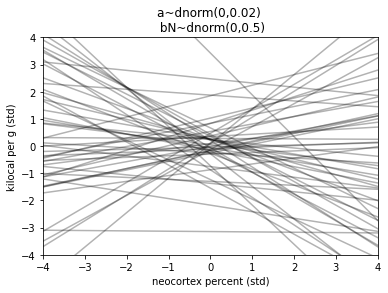

In [27]:
xseq = [-4, 4]
shared_N.set_value(np.array(xseq))
with m5_5:
    m5_5prior = pm.sample_prior_predictive()
fig, ax = plt.subplots()

for i in range(50):
    ax.plot(xseq, m5_5prior["K"][i], c="black", alpha=0.3)
ax.set_xlim(xseq)
ax.set_ylim(xseq)
ax.set_title("a~dnorm(0,0.02) \n bN~dnorm(0,0.5)")
ax.set_xlabel("neocortex percent (std)")
ax.set_ylabel("kilocal per g (std)");

In [30]:
az.summary(m5_5_trace, var_names=["a", "bN", "sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.038,0.165,-0.250,0.340,0.005,0.005,1062.0,622.0,1054.0,846.0,1.0
bN,0.108,0.252,-0.355,0.616,0.008,0.007,1116.0,579.0,1165.0,612.0,1.0
sigma,1.112,0.201,0.765,1.509,0.006,0.004,1043.0,1022.0,1043.0,714.0,1.0


No realation?

100%|██████████| 4000/4000 [00:18<00:00, 217.14it/s]
/Users/gokhansahin/opt/anaconda3/envs/MCelreath-pymc3/lib/python3.8/site-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/Users/gokhansahin/opt/anaconda3/envs/MCelreath-pymc3/lib/python3.8/site-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


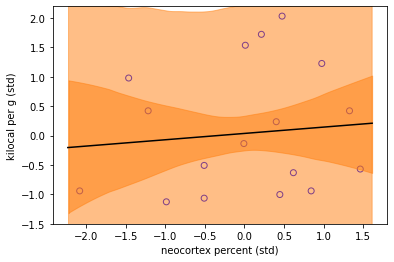

In [35]:
xseq = np.linspace(dcc["N"].min() - 0.15, dcc["N"].max() + 0.15, 30)

shared_N.set_value(xseq)

with m5_5:
    m5_5_posterior_predictive = pm.sample_posterior_predictive(
        m5_5_trace, var_names=["mu","K"], samples=4000
    )

mu_mean = m5_5_posterior_predictive["mu"].mean(axis=0)

fig, ax = plt.subplots()
ax.plot(xseq, mu_mean, c="black")
ax.scatter(dcc["N"], dcc["K"], facecolors="none", edgecolors="b")
az.plot_hpd(xseq, m5_5_posterior_predictive["mu"], ax=ax)
az.plot_hpd(xseq, m5_5_posterior_predictive["K"], ax=ax)
ax.set_ylim(-1.5, 2.2)
ax.set_xlabel("neocortex percent (std)")
ax.set_ylabel("kilocal per g (std)");

Now consider another predictor variable, adult female body mass, mass in the data frame. Now we construct a similar model, but consider the regression between kilocalories and body mass:

In [37]:
shared_M = shared(dcc["M"].values)

with pm.Model() as m5_6:
    sigma = pm.Exponential("sigma", 1)
    bM = pm.Normal("bM", 0, 0.5)
    a = pm.Normal("a", 0, 0.2)
    mu = pm.Deterministic("mu", a + bM * shared_M)

    K = pm.Normal("K", mu, sigma, observed=dcc["K"])

    m5_6_trace = pm.sample()

m5_6_data = az.from_pymc3(m5_6_trace)
az.summary(m5_6_trace, var_names=["bM", "a", "sigma"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bM, sigma]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:08<00:00, 242.02draws/s]
/Users/gokhansahin/opt/anaconda3/envs/MCelreath-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
bM,-0.309,0.239,-0.771,0.105,0.008,0.006,875.0,782.0,914.0,666.0,1.00
a,0.058,0.159,-0.250,0.338,0.005,0.005,1062.0,550.0,1062.0,743.0,1.00
sigma,1.058,0.194,0.706,1.417,0.007,0.005,748.0,690.0,893.0,596.0,1.01


100%|██████████| 4000/4000 [00:02<00:00, 1780.41it/s]
/Users/gokhansahin/opt/anaconda3/envs/MCelreath-pymc3/lib/python3.8/site-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


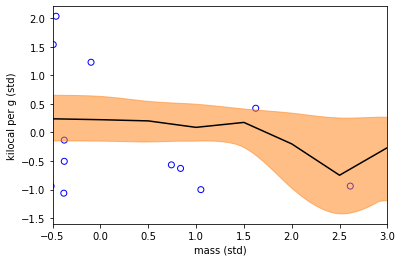

In [44]:
#xseq = np.linspace(dcc["M"].min() , dcc["M"].max() , 17)
xseq = np.linspace(-4,4, 17)
shared_N.set_value(xseq)

with m5_6:
    m5_6_posterior_predictive = pm.sample_posterior_predictive(
         m5_6_trace, var_names=["mu"], samples=4000
    )

mu_mean = m5_6_posterior_predictive["mu"].mean(axis=0)

fig, ax = plt.subplots()
ax.plot(xseq, mu_mean, c="black")
ax.scatter(dcc["M"], dcc["K"], facecolors="none", edgecolors="b")
az.plot_hpd(xseq, m5_6_posterior_predictive["mu"], ax=ax)
ax.set_xlim(-0.5, 3)
ax.set_xlabel("mass (std)")
ax.set_ylabel("kilocal per g (std)");

In [39]:
dcc['log_mass'] = np.log(dcc['mass'])
shared_M = shared(dcc["log_mass"].values)

with pm.Model() as m5_6p:
    sigma = pm.Exponential("sigma", 1)
    bM = pm.Normal("bM", 0, 0.5)
    a = pm.Normal("a", 0, 0.2)
    mu = pm.Deterministic("mu", a + bM * shared_M)

    K = pm.Normal("K", mu, sigma, observed=dcc["K"])

    m5_6p_trace = pm.sample()

m5_6p_data = az.from_pymc3(m5_6_trace)
az.summary(m5_6p_trace, var_names=["bM", "a", "sigma"])

<ipython-input-39-e82c27ce886e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dcc['log_mass'] = np.log(dcc['mass'])
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bM, sigma]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:07<00:00, 261.95draws/s]
/Users/gokhansahin/opt/anaconda3/envs/MCelreath-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
bM,-0.125,0.120,-0.340,0.113,0.005,0.004,572.0,537.0,571.0,611.0,1.0
a,0.118,0.176,-0.223,0.434,0.007,0.005,629.0,555.0,627.0,554.0,1.0
sigma,1.081,0.208,0.699,1.442,0.008,0.006,660.0,649.0,666.0,424.0,1.0


100%|██████████| 4000/4000 [00:02<00:00, 1427.74it/s]
/Users/gokhansahin/opt/anaconda3/envs/MCelreath-pymc3/lib/python3.8/site-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


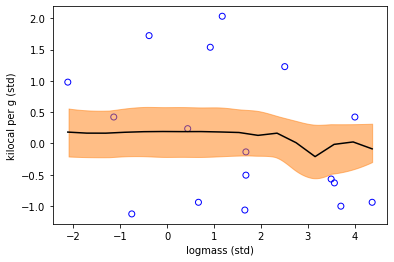

In [40]:
xseq = np.linspace(dcc["log_mass"].min() , dcc["log_mass"].max() , 17)

shared_N.set_value(xseq)

with m5_6:
    m5_6p_posterior_predictive = pm.sample_posterior_predictive(
         m5_6p_trace, var_names=["mu"], samples=4000
    )

mu_mean = m5_6p_posterior_predictive["mu"].mean(axis=0)

fig, ax = plt.subplots()
ax.plot(xseq, mu_mean, c="black")
ax.scatter(dcc["log_mass"], dcc["K"], facecolors="none", edgecolors="b")
az.plot_hpd(xseq, m5_6p_posterior_predictive["mu"], ax=ax)
#ax.set_xlim(-0.5, 3)
ax.set_xlabel("logmass (std)")
ax.set_ylabel("kilocal per g (std)");


Third model :Now let’s see what happens when we add both predictor variables at the same time to the
regression. This is the multivariate model, in math form:

Ki ∼ Normal(μi, σ)

μi = α + βNNi + βMMi

α ∼ Normal(0, 0.2)

βn ∼ Normal(0, 0.5)

βm ∼ Normal(0, 0.5)

σ ∼ Exponential(1)


In [45]:
shared_N = shared(dcc["N"].values)
shared_M = shared(dcc["log_mass"].values)

with pm.Model() as m5_7:
    sigma = pm.Exponential("sigma", 1)
    bN = pm.Normal("bN", 0, 0.5)
    bM = pm.Normal("bM", 0, 0.5)
    a = pm.Normal("a", 0, 0.2)

    mu = pm.Deterministic("mu", a + bN * shared_N + bM * shared_M)

    K = pm.Normal("K", mu, sigma, observed=dcc["K"])

    m5_7_trace = pm.sample(tune=2000, draws=10000)

m5_7_data = az.from_pymc3(m5_7_trace)
az.summary(m5_7_trace, var_names=["a", "bN", "bM", "sigma"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bM, bN, sigma]
Sampling 2 chains, 0 divergences: 100%|██████████| 24000/24000 [00:48<00:00, 496.90draws/s]
/Users/gokhansahin/opt/anaconda3/envs/MCelreath-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.197,0.184,-0.170,0.522,0.002,0.001,9332.0,9332.0,9323.0,12138.0,1.0
bN,0.409,0.278,-0.095,0.948,0.003,0.002,9744.0,9744.0,9779.0,11233.0,1.0
bM,-0.234,0.135,-0.484,0.019,0.001,0.001,9143.0,9143.0,9187.0,11775.0,1.0
sigma,0.982,0.201,0.652,1.366,0.002,0.001,11080.0,10952.0,11193.0,11926.0,1.0


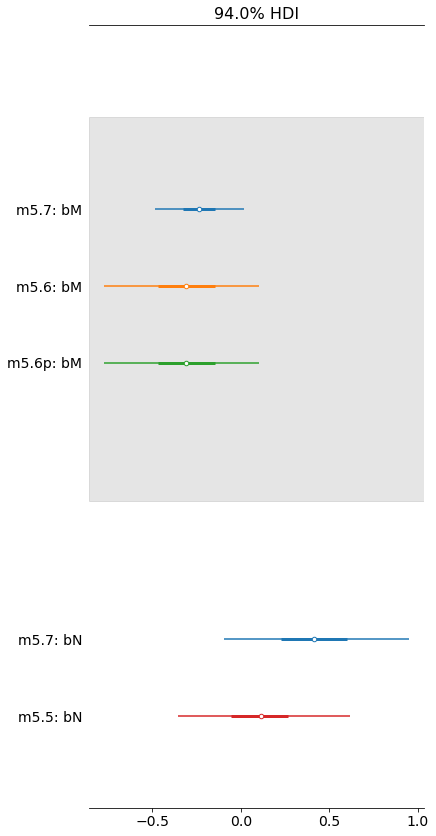

In [46]:
az.plot_forest(
    [m5_7_data, m5_6_data,m5_6p_data, m5_5_data],
    model_names=["m5.7", "m5.6","m5.6p", "m5.5"],
    var_names=["bM", "bN"],
    combined=True,
);


The posterior mean for the association of neocortex percent has increased fivefold, and its
89% interval is now entirely above zero. The posterior mean for log body mass has increased
2.5 times in magnitude.

This is a context in which there are two variables correlated with the outcome, but one is positively correlated with it and the other is negatively correlated with it.

In addition, both of the explanatory variables are positively correlated with one another.

As a result, they tend to cancel one another out.

This is another case in which multiple regression automatically finds the most revealing cases and uses them to produce inferences.

What the regression model does is ask if species that have high neocortex percent for their body mass have higher milk energy. Likewise, the model asks if species with high body mass for their neocortex percent have higher milk energy.

Bigger species, like apes, have milk with less energy. But species with more neocortex tend to have richer milk. The fact that these two variables, body size and neocortex, are correlated across species makes it hard to see these relationships, unless we account for both.







/Users/gokhansahin/opt/anaconda3/envs/MCelreath-pymc3/lib/python3.8/site-packages/pymc3/sampling.py:1246: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(
100%|██████████| 4000/4000 [00:02<00:00, 1378.42it/s]
/Users/gokhansahin/opt/anaconda3/envs/MCelreath-pymc3/lib/python3.8/site-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


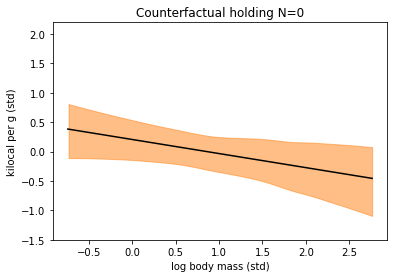

In [48]:
xseq = np.linspace(dcc["M"].min() - 0.15, dcc["M"].max() + 0.15, 30)
shared_N.set_value(np.zeros(30))
shared_M.set_value(xseq)


with m5_7:
    m5_7_posterior_predictive = pm.sample_posterior_predictive(
        m5_7_trace, var_names=["mu"], samples=4000
    )

mu_mean = m5_7_posterior_predictive["mu"].mean(axis=0)

fig, ax = plt.subplots()
ax.plot(xseq, mu_mean, c="black")
az.plot_hpd(xseq, m5_7_posterior_predictive["mu"], ax=ax)

ax.set_ylim(-1.5, 2.2)
ax.set_title("Counterfactual holding N=0")
ax.set_ylabel("kilocal per g (std)")
ax.set_xlabel("log body mass (std)");

<b>Categorical Values</b>

In [49]:
d = pd.read_csv('data/Howell1.csv', sep=';', header=0)

In [50]:
sex = d["male"].values

with pm.Model() as m5_8:
    sigma = pm.Uniform("sigma", 0, 50)
    mu = pm.Normal("mu", 178, 20, shape=2)
    height = pm.Normal("height", mu[sex], sigma, observed=d["height"])
    diff_fm = pm.Deterministic("diff", mu[0] - mu[1])
#This is
#the expected difference between a female and male in the sample. This kind of calculation is
#called a contrast. No matter how many categories you have, you can compute the contrast
#between any two by using samples from the posterior to compute their difference. Then you
#get the posterior distribution of the difference.
    m5_8_trace = pm.sample()

az.summary(m5_8_trace)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, sigma]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:09<00:00, 202.93draws/s]
/Users/gokhansahin/opt/anaconda3/envs/MCelreath-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu[0],134.994,1.683,131.981,137.977,0.048,0.034,1250.0,1246.0,1241.0,621.0,1.01
mu[1],142.673,1.719,139.708,145.780,0.052,0.036,1111.0,1110.0,1097.0,671.0,1.00
sigma,27.399,0.870,25.818,29.039,0.027,0.019,1077.0,1077.0,1060.0,527.0,1.01
diff,-7.679,2.368,-11.749,-3.101,0.069,0.051,1183.0,1077.0,1190.0,600.0,1.00


<b> Many Categories</b>

In [51]:
d = pd.read_csv('Data/milk.csv', sep=';')
d.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN


In [52]:


d["clade_id"] = pd.Categorical(d["clade"]).codes



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, sigma]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:07<00:00, 254.95draws/s]
/Users/gokhansahin/opt/anaconda3/envs/MCelreath-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


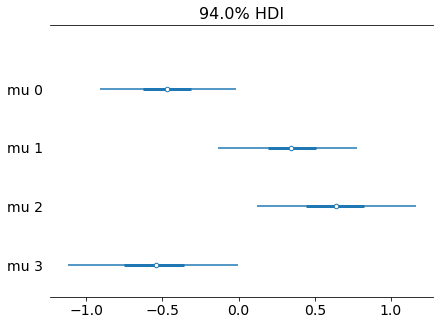

In [53]:
d["K"] = standardize(d["kcal.per.g"])

with pm.Model() as m5_9:
    sigma = pm.Exponential("sigma", 1)
    mu = pm.Normal("mu", 0, 0.5, shape=d["clade_id"].max() + 1)
    K = pm.Normal("K", mu[d["clade_id"]], sigma, observed=d["K"])

    m5_9_trace = pm.sample()

az.plot_forest(m5_9_trace, combined=True, var_names=["mu"]);